In [1]:
!pip install ipywidgets
!pip install torchviz

# Experiment 1: Small Transformer Classifier
This experiment trains a small, custom Transformer-based classifier from scratch on the Tagalog hate speech dataset.

**Goal:** Establish a baseline performance for a lightweight, non-pretrained Transformer model.

**Architecture:**
- **Embedding Layer:** Maps tokens to dense vectors.
- **Positional Encoding:** Adds information about token order.
- **Transformer Encoder Layer(s):** Self-attention mechanism to capture context.
- **Global Average Pooling:** Aggregates token representations into a single vector.
- **Classifier Head:** Linear layer to predict the class (Hate Speech vs. Not Hate Speech).

**Dataset:**
- Combined dataset from Hugging Face and GitHub sources.
- Preprocessed and split into Train, Validation, and Test sets.


In [2]:
import argparse
import copy
import json
import shutil
import sys
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from models.transformer import SmallTransformerClassifier
from utils.data_utils import SimpleTokenizer
from tqdm.auto import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Setup Dataset and Utility functions

In [4]:
class EncodedTextDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: SimpleTokenizer):
        self.labels = [int(l) for l in labels]
        self.encoded = [tokenizer.encode(t) for t in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.encoded[idx], dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [5]:
def load_dataframe(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError(f"File {path} must contain 'text' and 'label' columns.")
    return df[['text', 'label']]

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device) -> Tuple[float, Dict[str, float]]:
    model.eval()
    total_loss = 0.0
    metrics_accumulator: List[Dict[str, float]] = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        loss = criterion(logits, targets)
        total_loss += loss.item()
        metrics_accumulator.append(compute_metrics(logits.cpu(), targets.cpu()))

    return total_loss / max(len(loader), 1), aggregate_metrics(metrics_accumulator)


def compute_metrics(logits: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)

    tp = ((preds == 1) & (labels == 1)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        'accuracy': correct / total if total > 0 else 0.0,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def build_tokenizer(train_texts: List[str], extra_texts: Optional[List[str]], max_len: int) -> SimpleTokenizer:
    all_texts = list(train_texts)
    if extra_texts:
        all_texts.extend(extra_texts)
    return SimpleTokenizer(all_texts, max_len=max_len)

def create_dataloader(texts: List[str], labels: List[int], tokenizer: SimpleTokenizer, batch_size: int, shuffle: bool) -> DataLoader:
    dataset = EncodedTextDataset(texts, labels, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)


def aggregate_metrics(metric_list: List[Dict[str, float]]) -> Dict[str, float]:
    if not metric_list:
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    keys = metric_list[0].keys()
    return {k: float(np.mean([metrics[k] for metrics in metric_list])) for k in keys}



Trainer for the SimpleLM model

Setup model hyperparameters

In [6]:
EMBED_DIM=6
BATCH_SIZE=32
NUM_HEADS=2
NUM_LAYERS=2
DROPOUT=0.1
MAX_LEN=256
MIN_DELTA=1e-3
LEARNING_RATE=2e-4
CUDA_MIXED_PRECISION=True
GRAD_CLIP_NORM=1.0
WEIGHT_DECAY=1e-2
EPOCHS=250

In [7]:
TRAIN_CSV = Path('data/combined/processed/train.csv')
VAL_CSV = Path('data/combined/processed/validation.csv')
TEST_CSV = Path('data/combined/processed/test.csv')

train_df = load_dataframe(TRAIN_CSV)
val_df = load_dataframe(VAL_CSV)
test_df = load_dataframe(TEST_CSV)
extra_texts: Optional[List[str]] = None
extra_labels: Optional[List[int]] = None
train_texts = train_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()
if extra_texts and extra_labels:
    train_texts.extend(extra_texts)
    train_labels.extend(extra_labels)

val_texts = val_df['text'].astype(str).tolist()
val_labels = val_df['label'].astype(int).tolist()

test_texts = test_df['text'].astype(str).tolist()
test_labels = test_df['label'].astype(int).tolist()




In [8]:
model_hparams = {
    'embed_dim': EMBED_DIM,
    'num_heads': NUM_HEADS,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
    'max_len': MAX_LEN
}

In [9]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: Optional[torch.cuda.amp.GradScaler],
    device: torch.device,
    grad_clip: float,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    total_loss = 0.0
    metrics_accumulator: List[Dict[str, float]] = []

    autocast_enabled = scaler is not None and device.type == 'cuda'

    for batch_idx, (inputs, targets) in enumerate(loader, start=1):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=autocast_enabled):
            logits = model(inputs)
            loss = criterion(logits, targets)

        if scaler is not None:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        total_loss += loss.item()
        metrics_accumulator.append(compute_metrics(logits.detach().cpu(), targets.detach().cpu()))

    return total_loss / max(len(loader), 1), aggregate_metrics(metrics_accumulator)


In [10]:
extra_texts: Optional[List[str]] = None
extra_labels: Optional[List[int]] = None

In [11]:
tokenizer = build_tokenizer(
    train_df['text'].astype(str).tolist(),
    extra_texts,
    max_len=MAX_LEN,
)

In [12]:
model = SmallTransformerClassifier(
    vocab_size=tokenizer.vocab_size(),
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN,
    dropout=DROPOUT,
).to(device)

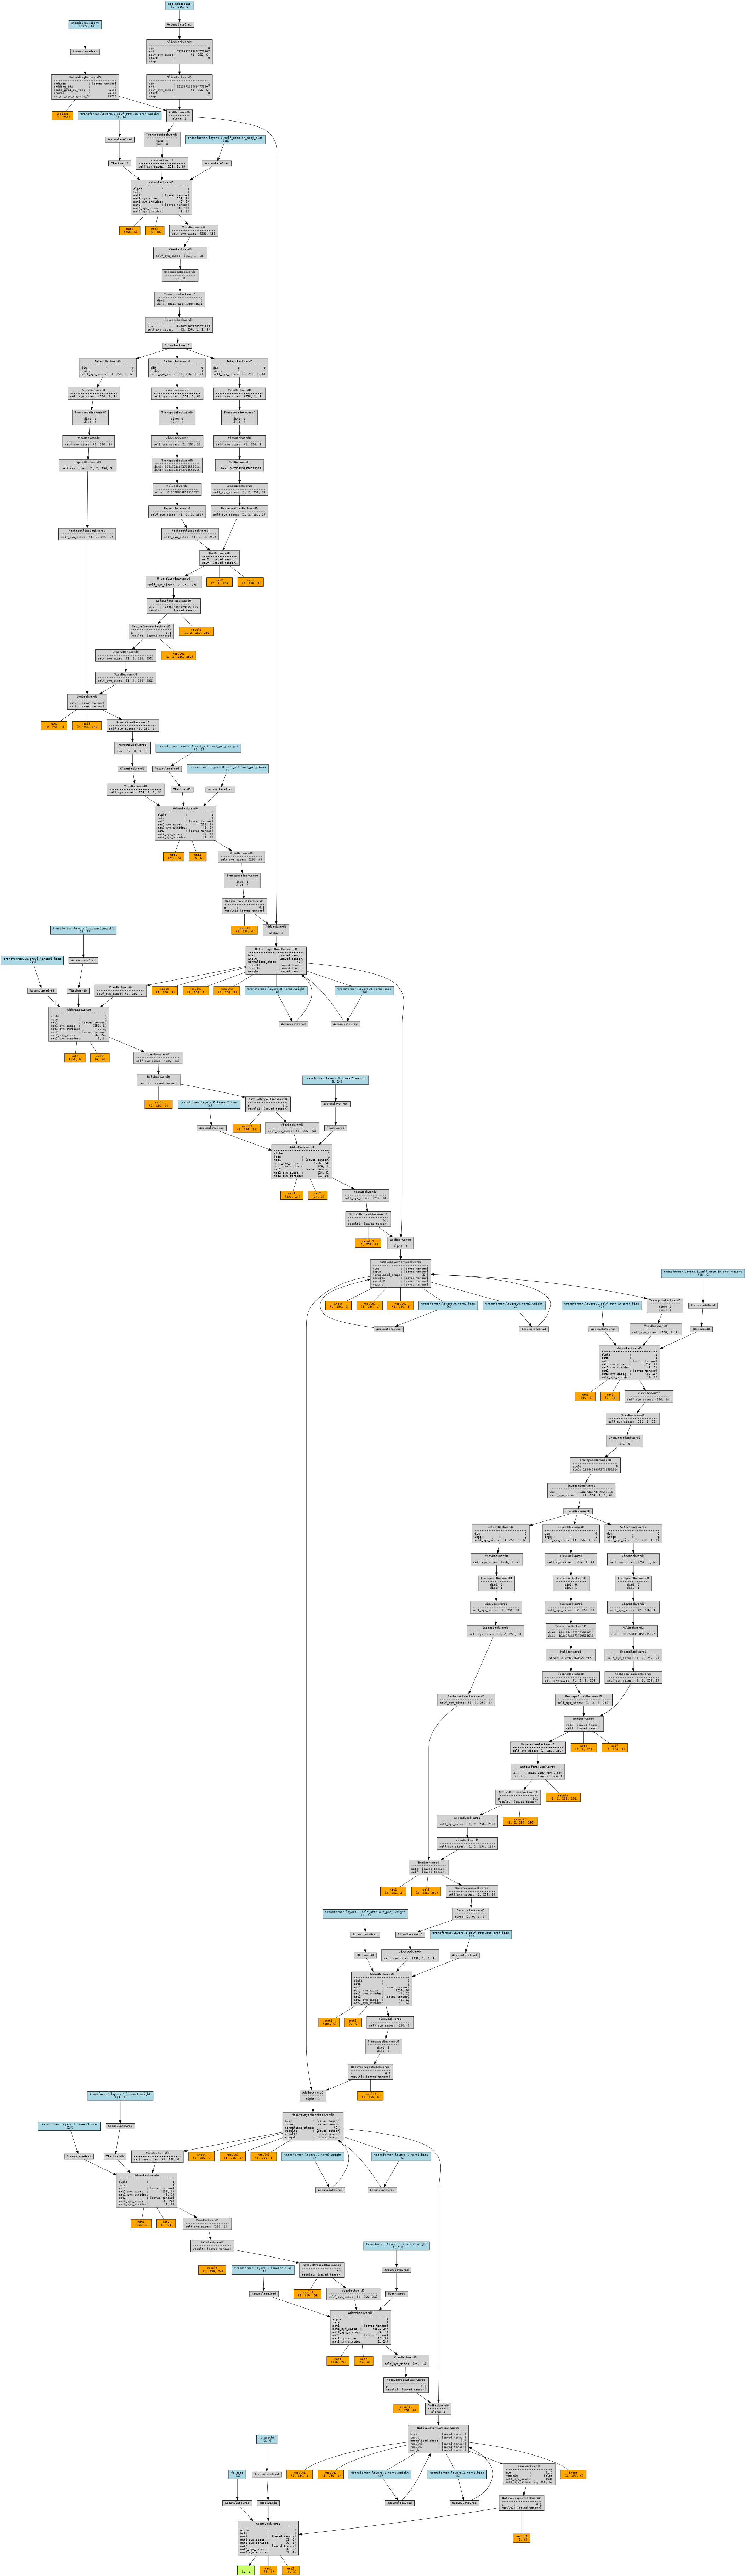

SmallTransformerClassifier(
  (embedding): Embedding(35772, 6, padding_idx=0)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=24, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=24, out_features=6, bias=True)
        (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=6, out_features=2, bias=True)
)


In [13]:
# Visualize Model Architecture
try:
    from torchviz import make_dot
    
    # Create a dummy input
    dummy_input = torch.randint(0, tokenizer.vocab_size(), (1, MAX_LEN)).to(device)
    
    # Forward pass to get the output graph
    y = model(dummy_input)
    
    # Generate the dot graph
    dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
    dot.format = 'png'
    
    # Display in notebook
    from IPython.display import Image, display
    display(Image(dot.render("model_architecture", cleanup=True)))
    
except ImportError:
    print("torchviz not installed. Install it via `pip install torchviz` to visualize the graph.")
except Exception as e:
    print(f"Could not visualize model: {e}")

# Print model summary
print(model)

In [14]:
train_loader = create_dataloader(train_texts, train_labels, tokenizer, BATCH_SIZE, shuffle=True)
val_loader = create_dataloader(val_texts, val_labels, tokenizer, BATCH_SIZE, shuffle=False)
test_loader = create_dataloader(test_texts, test_labels, tokenizer, BATCH_SIZE, shuffle=False)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler(enabled=CUDA_MIXED_PRECISION and device.type == 'cuda')


In [16]:
def snapshot_best_state(epoch: int, val_loss: float, val_metrics: Dict[str, float]) -> Dict[str, object]:
    return {
        'model_state_dict': {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
        'epoch': epoch,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'model_hyperparams': copy.deepcopy(model_hparams),
    }

In [17]:
run_log_dir = Path('runs/processed') / datetime.now().strftime('%Y%m%d-%H%M%S')
run_log_dir.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_dir=str(run_log_dir))
history: List[Dict[str, Dict[str, float]]] = []
best_val_accuracy = float('-inf')
for epoch in tqdm(range(1, EPOCHS + 1)):
        train_loss, train_metrics = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            device,
            GRAD_CLIP_NORM,
        )
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device)

        scheduler.step()

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_metrics': train_metrics,
            'val_loss': val_loss,
            'val_metrics': val_metrics,
        })

        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/validation', val_loss, epoch)
            for metric_name, metric_value in train_metrics.items():
                writer.add_scalar(f'Metrics/train/{metric_name}', metric_value, epoch)
            for metric_name, metric_value in val_metrics.items():
                writer.add_scalar(f'Metrics/validation/{metric_name}', metric_value, epoch)
            lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('LearningRate', lr, epoch)

        print(
            f"Epoch {epoch}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f} | Val F1: {val_metrics['f1']:.4f}"
        )

        val_accuracy = val_metrics.get('accuracy', 0.0)
        improved = val_accuracy > best_val_accuracy + MIN_DELTA

        if improved:
            best_val_accuracy = val_accuracy
            best_val_loss = val_loss
            patience_counter = 0
            best_state = snapshot_best_state(epoch, val_loss, val_metrics)
            
            # Save best model
            save_dir = Path('models/experiment_1')
            save_dir.mkdir(parents=True, exist_ok=True)
            torch.save(best_state, save_dir / 'best_model.pt')
            print(f"Saved best model to {save_dir / 'best_model.pt'}")

            if writer is not None:
                writer.add_scalar('Metrics/validation/best_accuracy', best_val_accuracy, epoch)


model.load_state_dict(best_state['model_state_dict'])
test_loss, test_metrics = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_metrics['accuracy']:.4f} | Test F1: {test_metrics['f1']:.4f}")

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_3757250/126952282.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):


Epoch 1/250 | Train Loss: 0.7007 | Val Loss: 0.6950 | Val Acc: 0.5197 | Val F1: 0.4726
Saved best model to models/experiment_1/best_model.pt
Epoch 2/250 | Train Loss: 0.6886 | Val Loss: 0.6926 | Val Acc: 0.5368 | Val F1: 0.5117
Saved best model to models/experiment_1/best_model.pt
Epoch 2/250 | Train Loss: 0.6886 | Val Loss: 0.6926 | Val Acc: 0.5368 | Val F1: 0.5117
Saved best model to models/experiment_1/best_model.pt
Epoch 3/250 | Train Loss: 0.6847 | Val Loss: 0.6892 | Val Acc: 0.5549 | Val F1: 0.5200
Saved best model to models/experiment_1/best_model.pt
Epoch 3/250 | Train Loss: 0.6847 | Val Loss: 0.6892 | Val Acc: 0.5549 | Val F1: 0.5200
Saved best model to models/experiment_1/best_model.pt
Epoch 4/250 | Train Loss: 0.6777 | Val Loss: 0.6871 | Val Acc: 0.5654 | Val F1: 0.5365
Saved best model to models/experiment_1/best_model.pt
Epoch 4/250 | Train Loss: 0.6777 | Val Loss: 0.6871 | Val Acc: 0.5654 | Val F1: 0.5365
Saved best model to models/experiment_1/best_model.pt
Epoch 5/250 |

Plot training curves

Training curves saved to 'training_curves.png'


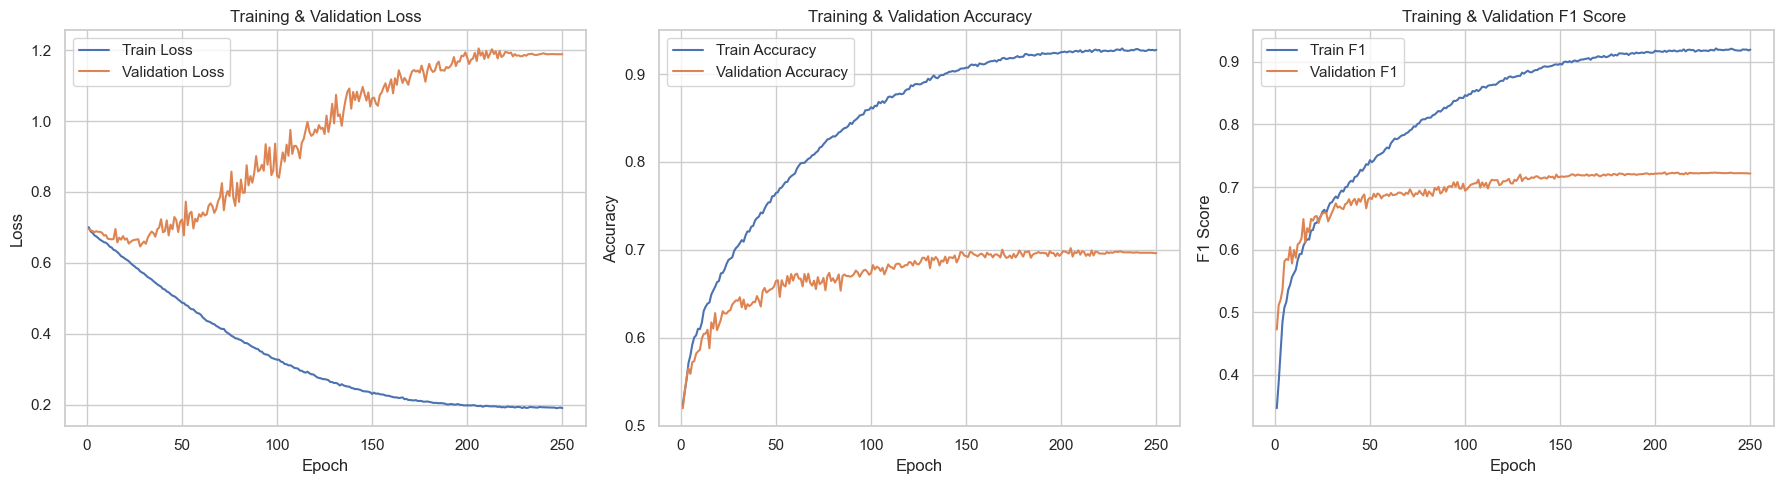

In [18]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    !pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns

# Extract data from history
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]

train_acc = [h['train_metrics']['accuracy'] for h in history]
val_acc = [h['val_metrics']['accuracy'] for h in history]

train_f1 = [h['train_metrics']['f1'] for h in history]
val_f1 = [h['val_metrics']['f1'] for h in history]

# Plotting
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss Plot
sns.lineplot(x=epochs, y=train_loss, ax=axes[0], label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[0], label='Validation Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy Plot
sns.lineplot(x=epochs, y=train_acc, ax=axes[1], label='Train Accuracy')
sns.lineplot(x=epochs, y=val_acc, ax=axes[1], label='Validation Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# F1 Score Plot
sns.lineplot(x=epochs, y=train_f1, ax=axes[2], label='Train F1')
sns.lineplot(x=epochs, y=val_f1, ax=axes[2], label='Validation F1')
axes[2].set_title('Training & Validation F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()

plt.tight_layout()

# Save the figure programmatically to avoid VS Code UI export issues
plt.savefig('training_curves.png', dpi=300)
print("Training curves saved to 'training_curves.png'")

plt.show()

Show final results

In [19]:
print("Final Test Results:")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_metrics['accuracy']:.4f} | Test F1: {test_metrics['f1']:.4f} | Test Precision: {test_metrics['precision']:.4f} | Test Recall: {test_metrics['recall']:.4f}")


Final Test Results:
Test Loss: 1.1540 | Test Acc: 0.6917 | Test F1: 0.7131 | Test Precision: 0.6091 | Test Recall: 0.8757


## Multi-run Experiment for Error Bars
The following cells define a procedure to run the training multiple times with different seeds to obtain error bars (mean ± std) for the performance metrics.

In [ ]:
def set_seed(seed: int):
    import random
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_run(seed: int):
    set_seed(seed)
    
    # Re-create dataloaders to ensure shuffling respects the new seed
    train_loader = create_dataloader(train_texts, train_labels, tokenizer, BATCH_SIZE, shuffle=True)
    val_loader = create_dataloader(val_texts, val_labels, tokenizer, BATCH_SIZE, shuffle=False)
    test_loader = create_dataloader(test_texts, test_labels, tokenizer, BATCH_SIZE, shuffle=False)
    
    model = SmallTransformerClassifier(
        vocab_size=tokenizer.vocab_size(),
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        max_len=MAX_LEN,
        dropout=DROPOUT,
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=CUDA_MIXED_PRECISION and device.type == 'cuda')
    
    best_val_accuracy = float('-inf')
    best_state = None
    
    # Use a unique log dir for each run
    run_log_dir = Path('runs/processed_multirun') / f"seed_{seed}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    run_log_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(log_dir=str(run_log_dir))
    
    # Use a simpler loop or tqdm without nesting too much
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, GRAD_CLIP_NORM
        )
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device)
        scheduler.step()
        
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Metrics/validation/accuracy', val_metrics['accuracy'], epoch)
        
        if val_metrics['accuracy'] > best_val_accuracy + MIN_DELTA:
            best_val_accuracy = val_metrics['accuracy']
            best_state = {
                'model_state_dict': {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
                'val_metrics': val_metrics
            }
            
    writer.close()
    
    # Load best model and evaluate on test
    if best_state:
        model.load_state_dict(best_state['model_state_dict'])
    
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device)
    return test_metrics

# Run experiment multiple times
NUM_RUNS = 1
seeds = [42 + i for i in range(NUM_RUNS)]
all_results = []

print(f"Starting {NUM_RUNS} runs...")
for seed in tqdm(seeds, desc="Runs"):
    result = train_run(seed)
    all_results.append(result)
    print(f"Seed {seed}: Test Acc: {result['accuracy']:.4f}, Test F1: {result['f1']:.4f}")

# Aggregate results
metrics_keys = all_results[0].keys()
final_metrics = {}
for k in metrics_keys:
    values = [r[k] for r in all_results]
    final_metrics[k] = {
        'mean': np.mean(values),
        'std': np.std(values)
    }

print("\nFinal Results with Error Bars:")
for k, v in final_metrics.items():
    print(f"{k}: {v['mean']:.4f} ± {v['std']:.4f}")

Starting 1 runs...


Runs:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_3757250/126952282.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):


Model Demo

## Interactive Testing
Use the widget below to test the model with your own text inputs.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        # Tokenize and move to device
        encoded = torch.tensor([tokenizer.encode(text)], dtype=torch.long).to(device)
        
        # Forward pass
        logits = model(encoded)
        probs = torch.softmax(logits, dim=1)
        
        # Get prediction
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()
        
    label_map = {0: "Not Hate Speech", 1: "Hate Speech"}
    return label_map[prediction], confidence

# Create Widgets
text_input = widgets.Textarea(
    value='',
    placeholder='Type something here (e.g., "Ang ganda ng araw ngayon" or something toxic)...',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='60%', height='100px')
)

button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict sentiment',
    icon='check'
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        text = text_input.value.strip()
        if not text:
            print("Please enter some text to analyze.")
            return
            
        try:
            label, conf = predict_sentiment(text)
            
            # Color code the output
            color = "green" if label == "Not Hate Speech" else "red"
            from IPython.display import HTML
            display(HTML(f"<h3>Prediction: <span style='color:{color}'>{label}</span></h3>"))
            print(f"Confidence: {conf:.2%}")
        except Exception as e:
            print(f"Error during prediction: {e}")

button.on_click(on_button_clicked)

# Display layout
display(widgets.VBox([
    widgets.Label("Enter Tagalog text to classify:"),
    text_input, 
    button, 
    output
]))

In [ ]:
# Qualitative Analysis: False Positives and False Negatives
import pandas as pd
import torch
from IPython.display import display

# Set pandas display options to show full text content
pd.set_option('display.max_colwidth', None)

def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(targets.numpy())
            
    return all_preds, all_probs, all_labels

# Get predictions on the test set
# Note: test_loader was created with shuffle=False, so the order matches test_df
if 'model' in locals() and 'test_loader' in locals() and 'device' in locals():
    preds, probs, labels = get_all_predictions(model, test_loader, device)

    # Create a DataFrame for analysis
    analysis_df = test_df.copy()
    analysis_df['prediction'] = preds
    # Get the probability of the predicted class
    analysis_df['confidence'] = [p[pred] for p, pred in zip(probs, preds)]
    analysis_df['correct'] = analysis_df['label'] == analysis_df['prediction']

    # Identify False Positives (Label=0, Pred=1) and False Negatives (Label=1, Pred=0)
    fp_df = analysis_df[(analysis_df['label'] == 0) & (analysis_df['prediction'] == 1)]
    fn_df = analysis_df[(analysis_df['label'] == 1) & (analysis_df['prediction'] == 0)]

    print(f"Total Test Samples: {len(analysis_df)}")
    print(f"False Positives: {len(fp_df)}")
    print(f"False Negatives: {len(fn_df)}")

    print("\n--- Sample False Positives (Predicted Hate, Actual Not Hate) ---")
    # Display top 20 with highest confidence (most 'wrong')
    if not fp_df.empty:
        display(fp_df.sort_values(by='confidence', ascending=False).head(20)[['text', 'label', 'prediction', 'confidence']])
    else:
        print("No False Positives found.")

    print("\n--- Sample False Negatives (Predicted Not Hate, Actual Hate) ---")
    if not fn_df.empty:
        display(fn_df.sort_values(by='confidence', ascending=False).head(20)[['text', 'label', 'prediction', 'confidence']])
    else:
        print("No False Negatives found.")
else:
    print("Model, test_loader, or device not found. Please run the training cells first.")